<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/education_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 教育

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
score_name = '教育スコア'
output_score_file = 'education_score.csv'

### 人口マスタ

In [6]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_pop_master.shape)

(3145, 6)


### 学校

In [7]:
df_school_master = pd.read_csv(os.path.join(DIR_NAME, 'public_school_master.csv'))[['学校番号', '施設分類', '学校名', '名称', '緯度', '経度', 'rating']]
df_school_master['学校番号'] = df_school_master['学校番号'].astype(str)
print(df_school_master.shape)

(1363, 7)


In [8]:
df_school_master.head()

,学校番号,施設分類,学校名,名称,緯度,経度,rating
0,101150,幼稚園,麹町,千代田区立麹町幼稚園,35.685691,139.740164,0.0
1,101160,幼稚園,九段,千代田区立九段幼稚園,35.690666,139.741195,0.0
2,101170,幼稚園,番町,千代田区立番町幼稚園,35.687629,139.733426,5.0
3,101190,幼稚園,お茶の水,千代田区立お茶の水幼稚園,35.697445,139.748569,4.0
4,101200,幼稚園,千代田,千代田区立千代田幼稚園,35.693169,139.768274,0.0


### 図書館

In [9]:
df_library_score = pd.read_csv(os.path.join(DIR_NAME, 'library_score.csv'))[['地域ID', '図書館(最近傍距離)', '図書館(平均距離)', '図書館(数)']]
print(df_library_score.shape)

(3145, 4)


In [10]:
df_library_score.head()

,地域ID,図書館(最近傍距離),図書館(平均距離),図書館(数)
0,101003,1.286453,1.301848,5
1,101004,1.242295,1.349516,5
2,101005,1.000856,1.274480,4
3,101007,0.687988,1.136131,5
4,101008,0.772108,1.182786,6


In [11]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].reset_index(drop=True)
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'min_param':
            # 最小の距離の時の他のパラメータを返す
            min_idx = dist.idxmin()
            if np.isnan(min_idx):
                val = np.NaN
            else:
                val = _df_cat.iloc[min_idx][param]
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

### スコア

In [12]:
%%time
# 一番近い施設の距離
df_pop_master['小学校(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '小学校', 'min')
# 一番近い施設の距離
df_pop_master['中学校(最近傍距離)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '中学校', 'min')
# 最寄りの小学校
df_pop_master['小学校(学校番号)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '小学校', 'min_param', '学校番号')
# 最寄りの中学校
df_pop_master['中学校(学校番号)'] = get_value_of_nearest_facility(df_pop_master, df_school_master, '中学校', 'min_param', '学校番号')

CPU times: user 3min 10s, sys: 855 ms, total: 3min 11s
Wall time: 3min 17s


In [13]:
df_pop_master.head()

,地域ID,市区町村名,町名,町丁目,緯度,経度,小学校(最近傍距離),中学校(最近傍距離),小学校(学校番号),中学校(学校番号)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,0.342000,1.700911,202010,301060
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,0.524351,1.630921,202010,302050
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,0.557686,1.277244,202010,302050
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0.555875,0.961946,202090,301060
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0.258117,1.364439,202090,301060


In [14]:
df_pop_master_merge = pd.merge(
    df_pop_master, 
    df_school_master[['学校番号', '名称', 'rating']].rename(columns={'学校番号': '小学校(学校番号)', '名称':'最寄りの小学校', 'rating':'小学校のレーティング'}), 
    on='小学校(学校番号)', how='left'
)
df_pop_master_merge = pd.merge(
    df_pop_master_merge, 
    df_school_master[['学校番号', '名称', 'rating']].rename(columns={'学校番号': '中学校(学校番号)', '名称':'最寄りの中学校', 'rating':'中学校のレーティング'}), 
    on='中学校(学校番号)', how='left'
)
df_pop_master_merge = pd.merge(
    df_pop_master_merge,
    df_library_score,
    on='地域ID', how='left'
)
print(df_pop_master_merge.shape)

(3145, 17)


In [15]:
assert len(df_pop_master_merge) == len(df_pop_master)
df_pop_master = df_pop_master_merge

In [16]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 17)


,地域ID,市区町村名,町名,町丁目,緯度,経度,小学校(最近傍距離),中学校(最近傍距離),小学校(学校番号),中学校(学校番号),最寄りの小学校,小学校のレーティング,最寄りの中学校,中学校のレーティング,図書館(最近傍距離),図書館(平均距離),図書館(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,0.342000,1.700911,202010,301060,中央区立城東小学校,4.1,千代田区立神田一橋中学校,3.5,1.286453,1.301848,5
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,0.524351,1.630921,202010,302050,中央区立城東小学校,4.1,中央区立銀座中学校,3.5,1.242295,1.349516,5
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,0.557686,1.277244,202010,302050,中央区立城東小学校,4.1,中央区立銀座中学校,3.5,1.000856,1.274480,4
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,0.555875,0.961946,202090,301060,中央区立常盤小学校,4.2,千代田区立神田一橋中学校,3.5,0.687988,1.136131,5
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,0.258117,1.364439,202090,301060,中央区立常盤小学校,4.2,千代田区立神田一橋中学校,3.5,0.772108,1.182786,6


In [17]:
feature_list = {
    '小学校(最近傍距離)': {'high': False, 'outlier': True, 'weight': 1}, 
    '中学校(最近傍距離)': {'high': False, 'outlier': True, 'weight': 1}, 
    '小学校のレーティング': {'high': True, 'outlier': True, 'weight': 0.5}, 
    '中学校のレーティング': {'high': True, 'outlier': True, 'weight': 0.5}, 
    '図書館(最近傍距離)': {'high': False, 'outlier': True, 'weight': 0.4}, 
    '図書館(平均距離)': {'high': False, 'outlier': True, 'weight': 0.2}, 
    '図書館(数)': {'high': True, 'outlier': False, 'weight': 0.3},
}

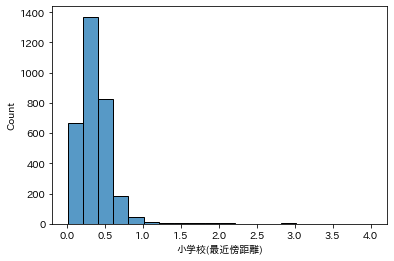

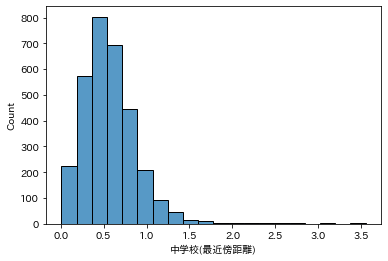

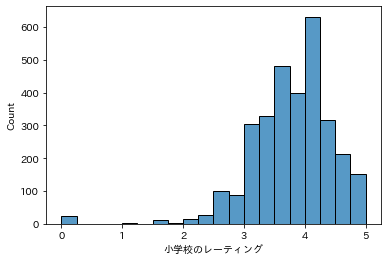

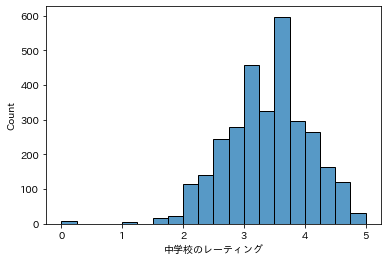

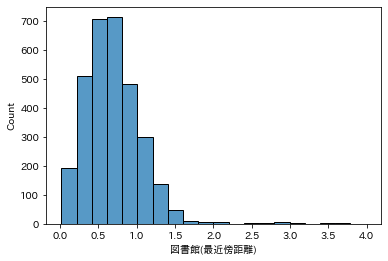

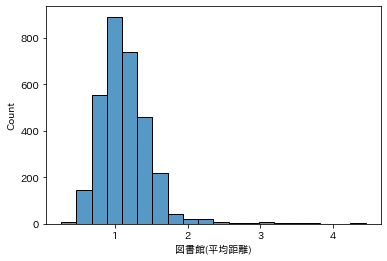

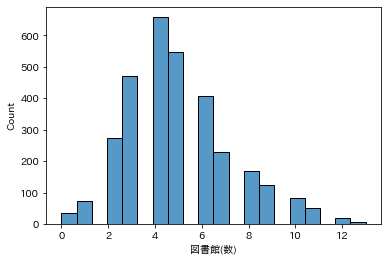

In [18]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [19]:
def normalize_score(sr_data, high=True, outlier=True):
    score = (sr_data - sr_data.mean())/sr_data.std()
    score = score if high else -score

    if outlier:
        high_s = score.quantile(0.99)
        low_s = score.quantile(0.01)
        score[score > high_s] = high_s
        score[score < low_s] = low_s
    else:
        high_s = score.max()
        low_s = score.min()
        
    return (score - low_s)/(high_s - low_s)


def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

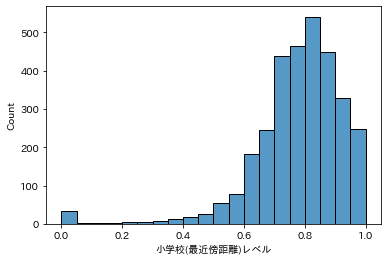

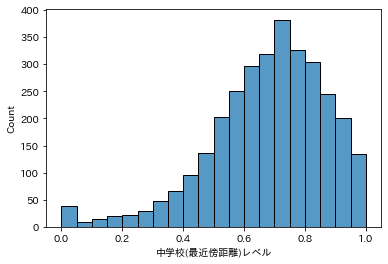

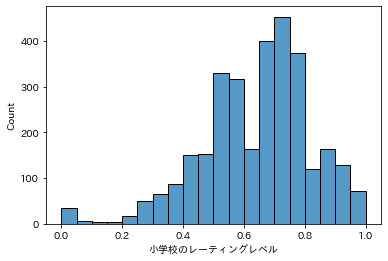

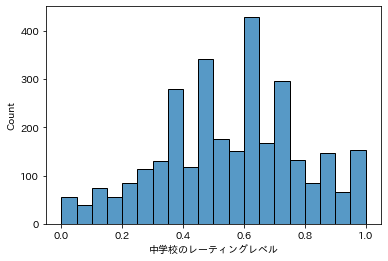

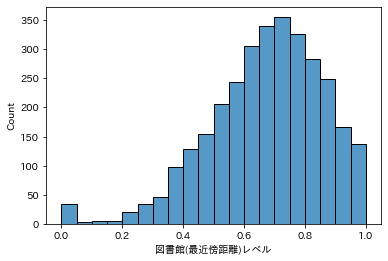

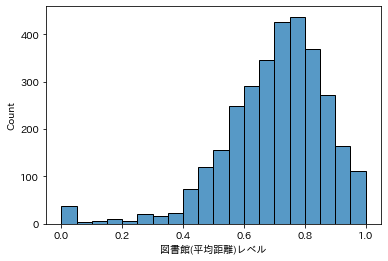

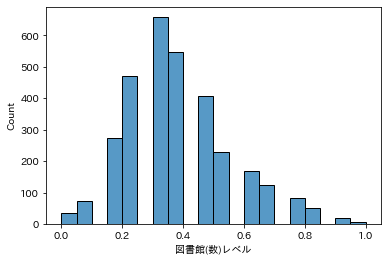

In [20]:
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = normalize_score(df_pop_master[key], high=value['high'], outlier=value['outlier'])
    sns.histplot(df_pop_master[f'{key}レベル'], bins=20)
    plt.show()

In [21]:
score_list = []
for key, value in feature_list.items():
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

score_sub_name = '_' + score_name
df_pop_master[score_sub_name] = normalize_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False), outlier=False)
df_pop_master[score_name] = rank_score(df_pop_master[score_sub_name])

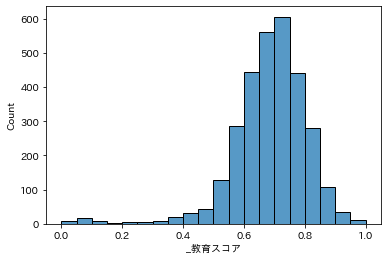

In [22]:
sns.histplot(df_pop_master[score_sub_name], bins=20)
plt.show()

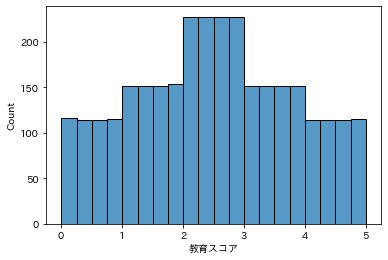

In [23]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [24]:
df_pop_master[
    ['地域ID', '市区町村名', '町丁目'] + list(feature_list.keys()) + ['最寄りの小学校', '最寄りの中学校'] + [score_sub_name, score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

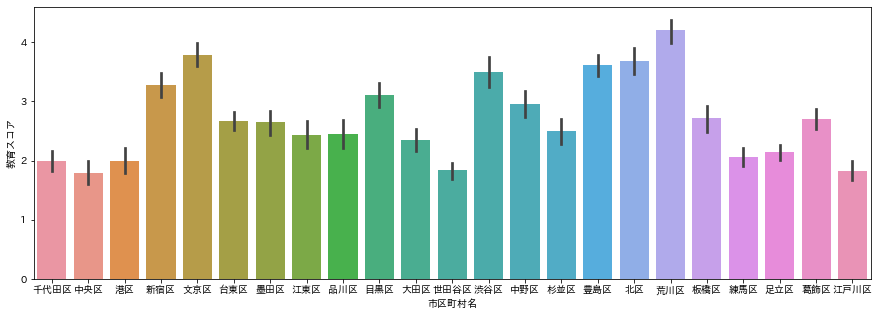

In [25]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [26]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + [score_name, score_sub_name] + list(feature_list.keys()) + ['最寄りの小学校', '最寄りの中学校']
].reset_index(drop=True)
print(df_level.shape)

(891, 14)


In [27]:
df_level.head(20)

,市区町村名,町名,町丁目,教育スコア,_教育スコア,小学校(最近傍距離),中学校(最近傍距離),小学校のレーティング,中学校のレーティング,図書館(最近傍距離),図書館(平均距離),図書館(数),最寄りの小学校,最寄りの中学校
0,新宿区,市谷山伏町,市谷山伏町,5.000000,1.000000,0.054941,0.184149,5.0,4.6,0.565875,0.917004,10,新宿区立市谷小学校,新宿区立牛込第一中学校
1,新宿区,北山伏町,北山伏町,4.997811,0.997757,0.124839,0.031435,5.0,4.6,0.396628,0.903900,7,新宿区立市谷小学校,新宿区立牛込第一中学校
2,北区,田端,田端５丁目,4.995623,0.979256,0.089585,0.286096,4.7,4.4,0.380644,0.553556,11,北区立田端小学校,北区立田端中学校
3,新宿区,早稲田南町,早稲田南町,4.993434,0.979078,0.045990,0.070585,4.1,4.3,0.350008,0.800015,9,新宿区立早稲田小学校,新宿区立牛込第二中学校
4,文京区,千石,千石２丁目,4.989057,0.964647,0.119029,0.161431,4.6,4.2,0.486254,0.673157,10,文京区立林町小学校,文京区立第十中学校
5,新宿区,新宿,新宿６丁目,4.986868,0.964282,0.029122,0.042817,4.8,3.9,0.633700,0.731984,8,新宿区立天神小学校,新宿区立新宿中学校
6,新宿区,市谷甲良町,市谷甲良町,4.984679,0.963741,0.115221,0.232495,5.0,4.6,0.542614,0.962649,8,新宿区立市谷小学校,新宿区立牛込第一中学校
7,新宿区,喜久井町,喜久井町,4.982491,0.962979,0.106959,0.084254,4.1,4.3,0.464016,0.816353,10,新宿区立早稲田小学校,新宿区立牛込第二中学校
8,北区,上十条,上十条３丁目,4.978113,0.949701,0.200028,0.175064,4.2,3.8,0.081841,0.572226,12,北区立王子第五小学校,板橋区立加賀中学校
9,中野区,鷺宮,鷺宮４丁目,4.973736,0.944722,0.302452,0.049439,4.8,5.0,0.370342,0.987145,6,中野区立鷺宮小学校,中野区立第八中学校


In [28]:
df_level.tail(20)

,市区町村名,町名,町丁目,教育スコア,_教育スコア,小学校(最近傍距離),中学校(最近傍距離),小学校のレーティング,中学校のレーティング,図書館(最近傍距離),図書館(平均距離),図書館(数),最寄りの小学校,最寄りの中学校
871,港区,台場,台場１丁目,0.321733,0.498906,0.329165,0.347182,3.9,0.0,2.609301,2.816904,0,港区立港陽小学校,港区立港陽中学校
872,中央区,豊海町,豊海町,0.319545,0.498257,0.180911,1.408039,4.2,3.5,1.515568,1.780800,3,中央区立豊海小学校,中央区立銀座中学校
873,千代田区,丸の内,丸の内３丁目,0.312979,0.497120,0.557686,1.277244,4.1,3.5,1.000856,1.274480,4,中央区立城東小学校,中央区立銀座中学校
874,大田区,昭和島,昭和島１丁目,0.295469,0.484177,0.615712,1.045750,3.5,3.1,0.950472,1.332220,4,大田区立中富小学校,大田区立大森東中学校
875,葛飾区,水元公園,水元公園,0.280149,0.478109,0.371924,0.725703,2.4,2.3,1.007966,1.693609,2,葛飾区立東水元小学校,葛飾区立水元中学校
876,中央区,八重洲１丁目,八重洲１丁目,0.277960,0.475909,0.387197,1.811104,4.1,3.6,0.956286,1.171812,4,中央区立城東小学校,中央区立日本橋中学校
877,品川区,八潮,八潮１丁目,0.267017,0.469862,0.887276,0.546137,4.5,2.1,1.263154,1.665337,2,品川区立城南第二小学校,品川区立東海中学校
878,千代田区,霞が関,霞が関１丁目,0.264828,0.468691,0.769874,1.398434,3.4,4.0,0.268680,1.200563,3,中央区立泰明小学校,港区立御成門中学校
879,大田区,羽田空港,羽田空港１丁目,0.221055,0.440664,1.241860,0.633155,3.8,3.8,1.344716,1.674860,3,大田区立東糀谷小学校,大田区立羽田中学校
880,港区,海岸,海岸１丁目,0.218866,0.439910,0.891430,1.157685,4.2,3.5,1.168507,1.620538,5,中央区立豊海小学校,中央区立銀座中学校
